In [2]:
#%pip install xgboost
#%pip install lightgbm

In [3]:
#!/usr/bin/env python3
import numpy as np
import math

import seaborn as sns
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt
import pandas as pd


from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Keep 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Remove 'Id' colum
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#after removing 'Id'
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


# Target Variable: SalePrice

[Text(0.5, 1.0, 'SalePrice distribution')]

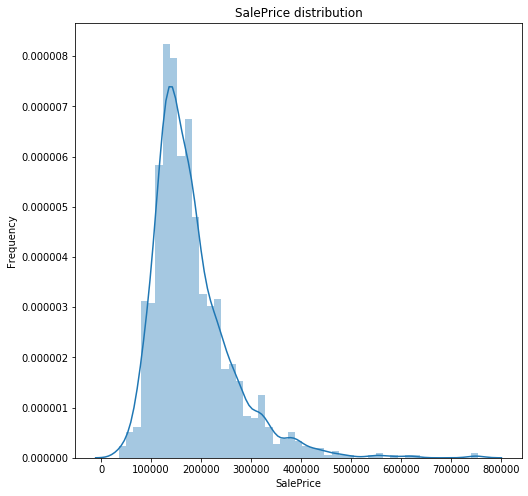

In [6]:
f, ax = plt.subplots(figsize=(8, 8))
sns.distplot(train['SalePrice']);
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

SalePrice is skewed to the left. We apply log(1+x) transform to correct this.

[Text(0.5, 1.0, 'SalePrice distribution')]

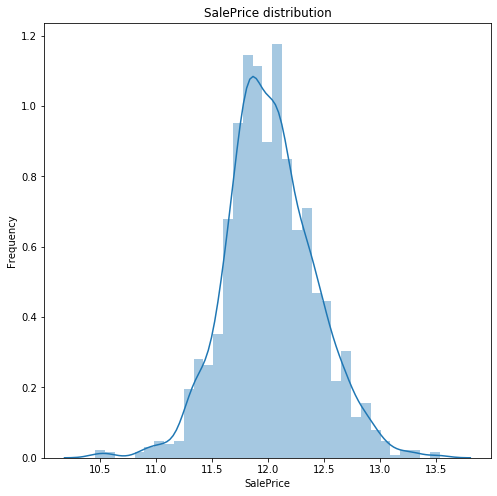

In [7]:
train["SalePrice"] = np.log1p(train["SalePrice"])
ax = plt.subplots(figsize=(8, 8))
ax = sns.distplot(train['SalePrice']);
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

In [8]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() * 100 / len(train)).sort_values(ascending=False)
missing_value_df = pd.DataFrame({'Total': total, 'Percentage Missing': percent})
missing_value_df.head(20)

,Total,Percentage Missing
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageCond,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


Hence, as percentage missing value is > 20%, we drop these covariates in both training and test sets. 

In [9]:
train = train.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],axis=1)
test = test.drop(['Alley','PoolQC','Fence','MiscFeature','FireplaceQu'],axis=1)

# Dealing with missing data one by one

- Lot Frontage - to determine if it is better to fill in missing values with median or mean, look at distribution when missing values are removed 

[Text(0.5, 1.0, 'LotFrontage distribution')]

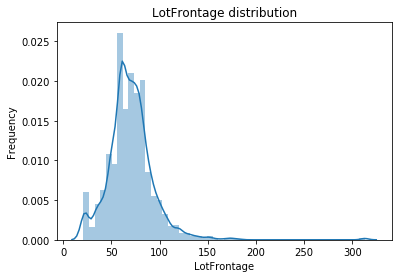

In [10]:
lf = train['LotFrontage'].dropna()
a = sns.distplot(lf);
a.set(ylabel="Frequency")
a.set(xlabel="LotFrontage")
a.set(title="LotFrontage distribution")

In [11]:
print("Number of observations remaining: ", len(lf))
print("Number of observations whose LotFrontage is above 140 is: ", len(lf[lf > 140]))

Number of observations remaining:  1201
Number of observations whose LotFrontage is above 140 is:  13


Since there are around more than 1% of the data whose value is significant more than the mean, we use median imputation. 

In [12]:
train['LotFrontage'] = train['LotFrontage'].fillna(train.LotFrontage.mean())
test['LotFrontage'] = test['LotFrontage'].fillna(test.LotFrontage.mean())

From text description, we will fill the missing values for BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, GarageCond, and MasVnrType with "None" since these houses are missing a basement or garage or fireplace.

In [13]:
col_none = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'GarageType','GarageFinish','GarageQual','GarageCond']
train[col_none]= train[col_none].fillna('None')
test[col_none]= test[col_none].fillna('None')

We also fill some other features with its respective modes. 

In [14]:
col_freq = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType',
                      'Electrical','KitchenQual','Functional','SaleType']
train[col_freq] = train[col_freq].fillna(train[col_freq].mode().iloc[0])
test[col_freq] = test[col_freq].fillna(test[col_freq].mode().iloc[0])

- Other variables to be considered

In [15]:
train.isnull().sum().sort_values(ascending=False).head(10)

GarageYrBlt    81
MasVnrArea      8
ExterCond       0
RoofStyle       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
ExterQual       0
SalePrice       0
dtype: int64

In [16]:
test.isnull().sum().sort_values(ascending=False).head(10)

GarageYrBlt     78
MasVnrArea      15
BsmtFullBath     2
BsmtHalfBath     2
TotalBsmtSF      1
GarageArea       1
BsmtUnfSF        1
BsmtFinSF1       1
GarageCars       1
BsmtFinSF2       1
dtype: int64

In [17]:
garage = train[['GarageYrBlt', 'GarageArea', 'GarageCars']]
garage[garage.GarageYrBlt.isnull()].head(10)

,GarageYrBlt,GarageArea,GarageCars
39,NaN,0,0
48,NaN,0,0
78,NaN,0,0
88,NaN,0,0
89,NaN,0,0
99,NaN,0,0
108,NaN,0,0
125,NaN,0,0
127,NaN,0,0
140,NaN,0,0


Hence, if there is no garage, there is no cars so we replace missing data with 0.

In [18]:
col_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars']
train[col_zero] = train[col_zero].fillna(0)
test[col_zero] = test[col_zero].fillna(0)

Similarly, if there is no basement or bath or masonry veneer, we replace missing data with 0.

In [19]:
col_zero_2 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
train[col_zero_2] = train[col_zero_2].fillna(0)
test[col_zero_2] = test[col_zero_2].fillna(0)

Checking that there is no more missing values

In [20]:
train.isnull().sum().sort_values(ascending=False).head(10)

SalePrice       0
YearRemodAdd    0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
Foundation      0
dtype: int64

In [21]:
test.isnull().sum().sort_values(ascending=False).head(10)

SaleCondition    0
YearRemodAdd     0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
dtype: int64

# Encoding ordinal variables: ordinal and binary 

In [22]:
train['train']  = 1
test['train']  = 0
df = pd.concat([train, test], axis=0,sort=False)

I could have created a df to combine train and test earlier to avoid applying the same method to fill in missing values earlier for both train and test data sets. 

Ordinal categorical variables - use LabelEncoder from skitlearn

In [23]:
cols = ('ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'YrSold', 'MoSold')
# apply LabelEncoder
for c in cols:
    le = LabelEncoder() 
    le.fit(list(df[c].values)) 
    df[c] = le.transform(list(df[c].values))

In [24]:
df.shape

(2919, 76)

# Correcting Skewness

In [25]:
#filter out continuous values
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75] #filter out covariates that have skewness over 0.75
skewed_feats = skewed_feats.index #find those indexes

df[skewed_feats] = np.log1p(df[skewed_feats])

In [26]:
df = pd.get_dummies(df)
df.shape

(2919, 215)

In [27]:
df_train = df[df['train'] == 1]
df_train = df_train.drop(['train',],axis=1)
df_train_price = df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

df_test = df[df['train'] == 0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [28]:
df_train.shape, df_train_price.shape, df_test.shape

((1460, 213), (1460,), (1459, 213))

# Modeling

In [29]:
kf = KFold(n_splits=5, random_state=40, shuffle=True)
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, df_train, df_train_price, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [30]:
lr = LinearRegression()
lr.fit(df_train, df_train_price)
cv_rmse(lr).mean()

0.132270767144893

Using Ridge Regression

In [31]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50])
ridge.fit(df_train, df_train_price)
alpha = ridge.alpha_
print('best alpha',alpha)
#ridge.min()

best alpha 5.0


In [32]:
cv_rmse(Ridge(alpha = alpha)).mean()

0.12633221183671095

In [33]:
lasso = LassoCV(alphas = [0.0001, 0.005, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3, 5]).fit(df_train, df_train_price)
alpha = lasso.alpha_
print('best alpha',alpha)

best alpha 0.0001


/Users/PeterK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [34]:
cv_rmse(lasso).mean()

/Users/PeterK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/PeterK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/PeterK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/PeterK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warn

0.1269185660868626

In [35]:
gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                max_depth=10, max_features='sqrt', min_samples_leaf=8, loss='huber',
                                min_samples_split=5)                             
cv_rmse(gbr).mean()

0.13286533096534817

In [36]:
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                max_depth=5, max_features='sqrt', min_samples_leaf=5, loss='huber',
                                min_samples_split=3)                             
cv_rmse(gbr).mean()

0.1285155785714196

In [37]:
xgboost = XGBRegressor(learning_rate=0.05,
                       n_estimators=1000,
                       max_depth=3,
                       reg_alpha=0.4, reg_lambda=0.8,
                       subsample=0.5)
cv_rmse(xgboost).mean()

0.12719282888758168

In [38]:
xgboost2 = XGBRegressor(colsample_bytree=0.5, gamma=0.05, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.8, n_estimators=2000,
                             reg_alpha=0.5, reg_lambda=0.9,
                             subsample=0.5, nthread = -1)
cv_rmse(xgboost2).mean()


0.12844716756040445

In [39]:
lgb = LGBMRegressor(objective='regression',num_leaves=8,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8)
cv_rmse(lgb).mean()


0.13360541674827398

In [40]:
lgb2 = LGBMRegressor(objective='regression',num_leaves=3,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 40, bagging_fraction = 0.7)
cv_rmse(lgb2).mean()


0.1306746419116735

In [41]:
gbr.fit(df_train, df_train_price)
predict_sp = gbr.predict(df_test)

In [42]:
predict_sp

array([11.7294196 , 12.00518804, 12.14337761, ..., 12.02088781,
       11.68242684, 12.31544059])

In [45]:
sp_non_log = np.expm1(predict_sp)
print(sp_non_log)

[124170.58082969 163600.36332337 187844.9719754  ... 166189.13684854
 118470.39732858 223113.54845467]


In [50]:
submission = pd.DataFrame({
        "Id": test_ID,
        "SalePrice": sp_non_log
    })
submission.to_csv('submission.csv', index=False)